# Hanabi game -- Analysis of simulation results

## Data import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product

In [2]:
path = "/home/nmontes/OneDrive/Documentos/PhD/hanabi-results/info-gain"

results = {}
results[True] = {}
results[False] = {}
player_configs = [2, 3, 4, 5]

for abd, n in product((True, False), player_configs):
    results_file = "{}/summary_{}_{}_players.csv".format(path, str(abd).lower(), n)
    df = pd.read_csv(results_file, sep=';', index_col="seed")

    # add efficiency as ratio score : hint
    eff = df.apply(lambda x: x.score/x.hints if x.hints > 0 else 0, axis=1)
    df.insert(df.shape[1], "efficiency", eff)
    
    results[abd][n] = df

## Summary plots

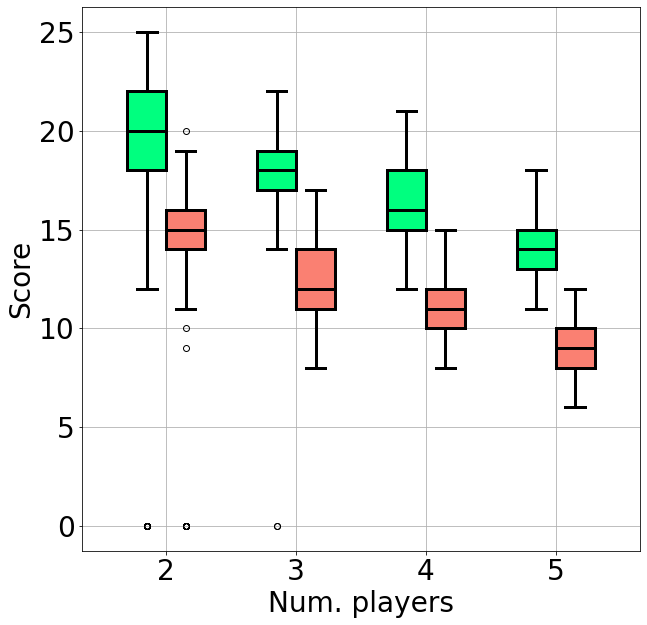

In [3]:
plt.rcParams.update({'font.size': 28})
fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')

epsilon = 0.15
lw = 3
colors = {True: 'springgreen', False: 'salmon'}

for n in player_configs:
    for abd in (True, False):
        if abd:
            x = n-epsilon
        else:
            x = n+epsilon
        data = results[abd][n]["score"].to_numpy()
        bp = ax.boxplot(
            data,
            positions=[x],
            widths=[epsilon*2],
            boxprops={'linewidth': lw},
            medianprops={'linewidth': lw, 'color': 'black'},
            capprops={'linewidth': lw},
            whiskerprops={'linewidth': lw},
            patch_artist=True
        )
        for patch in bp['boxes']:
            patch.set(facecolor=colors[abd])

ax.set_xticks(player_configs, labels=player_configs)
ax.grid()
ax.set_xlabel("Num. players")
ax.set_ylabel("Score")
# plt.savefig("score.png")
plt.show()

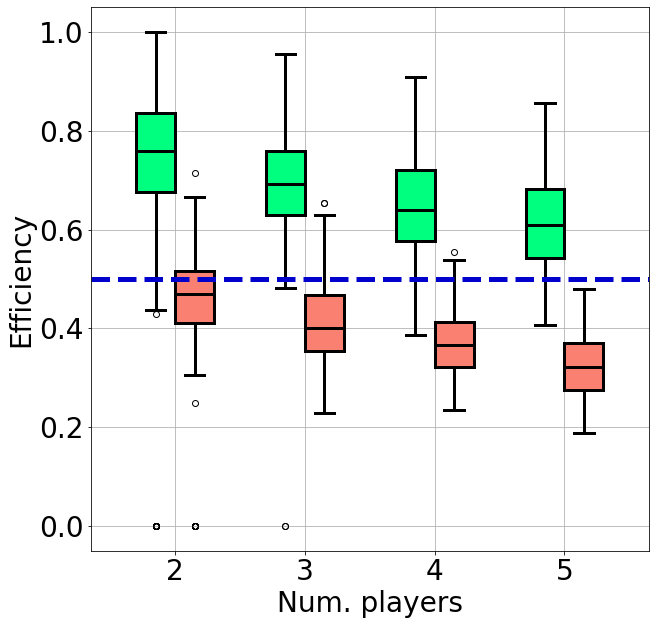

In [4]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')

for n in player_configs:
    for abd in (True, False):
        if abd:
            x = n-epsilon
        else:
            x = n+epsilon
        data = results[abd][n]["efficiency"].to_numpy()
        bp = ax.boxplot(
            data,
            positions=[x],
            widths=[epsilon*2],
            boxprops={'linewidth': lw},
            medianprops={'linewidth': lw, 'color': 'black'},
            capprops={'linewidth': lw},
            whiskerprops={'linewidth': lw},
            patch_artist=True
        )
        for patch in bp['boxes']:
            patch.set(facecolor=colors[abd])

ax.set_xticks(player_configs, labels=player_configs)
ax.grid()
ax.set_xlabel("Num. players")
ax.set_ylabel("Efficiency")
ax.axhline(0.5, linewidth=5, color='mediumblue', linestyle='--')
# plt.savefig("efficiency.png")
plt.show()

## Average information per hint

In [5]:
for abd, n in product((True, False), player_configs):
    total_explicit_info = {}
    avg_explicit_info = {}
    if abd:
        total_implicit_info = {}
        avg_implicit_info = {}

    for seed in range(500):
        results_file = "{}/info_gain_{}_{}_{}.csv".format(path, str(abd).lower(), n, seed)
        df = pd.read_csv(results_file, sep=';')
        explicit_info_all_slots = df.groupby(["move"])["explicit_info"].sum().replace(0, np.NaN)
        total_explicit_info[seed] = explicit_info_all_slots.sum()
        avg_explicit_info[seed] = explicit_info_all_slots.mean()
        if abd:
            implicit_info_all_slots = df.groupby(["move"])["implicit_info"].sum().replace(0, np.NaN)
            total_implicit_info[seed] = implicit_info_all_slots.sum()
            avg_implicit_info[seed] = implicit_info_all_slots.mean()

    results[abd][n]["total_explicit_info"] = pd.Series(total_explicit_info)
    results[abd][n]["avg_explicit_info"] = pd.Series(avg_explicit_info)
    if abd:
        results[abd][n]["total_implicit_info"] = pd.Series(total_implicit_info)
        results[abd][n]["avg_implicit_info"] = pd.Series(avg_implicit_info)

## Score rate that can be assigned to explicit and implicit information

In [8]:
for n in player_configs:
    score = {}
    explicit_info = {}

    score_rate = {}

    results[False][n]["score_rate"] = results[False][n]["score"] / results[False][n]["total_explicit_info"]
    score_rate['explicit'] = results[False][n]["score_rate"].mean()

    results[True][n]["score_by_expl_info"] = results[True][n]["total_explicit_info"]*score_rate['explicit']
    results[True][n]["residual_score"] = results[True][n]["score"] - results[True][n]["score_by_expl_info"]

    results[True][n]["impl_score_rate"] = results[True][n]["residual_score"] / results[True][n]["total_implicit_info"]
    score_rate['implicit'] = results[True][n]["impl_score_rate"].replace([np.inf, -np.inf], np.nan).mean()

    print("{} players:".format(n))
    print("Explicit score rate: {:.2f}".format(score_rate['explicit']))
    print("Implicit score rate: {:.2f}".format(score_rate['implicit']))
    print("Ratio of implicit to explicit score rate: {:.1f}\n".format(score_rate['implicit']/score_rate['explicit']))

2 players:
Explicit score rate: 0.70
Implicit score rate: 1.18
Ratio of implicit to explicit score rate: 1.7

3 players:
Explicit score rate: 0.60
Implicit score rate: 1.50
Ratio of implicit to explicit score rate: 2.5

4 players:
Explicit score rate: 0.61
Implicit score rate: 1.32
Ratio of implicit to explicit score rate: 2.2

5 players:
Explicit score rate: 0.52
Implicit score rate: 1.42
Ratio of implicit to explicit score rate: 2.7



## Linear correlations

In [47]:
from itertools import product
from sklearn.linear_model import LinearRegression

plt.rcParams.update({'font.size': 16})

def basic_plots(n, abd, regression_model=LinearRegression()):
    predictors = ["avg_explicit_info", "total_explicit_info"]
    if abd:
        predictors += ["avg_implicit_info", "total_implicit_info"]
    predicted = ["score", "efficiency"]

    fig, axs = plt.subplots(len(predictors), len(predicted), figsize=(15, 5*len(predictors)),
        facecolor = 'white')
    df = results[abd][n].loc[results[abd][n]["score"] > 0]
    corrs = pd.DataFrame(columns=['x', 'y', 'r2'])

    for i, j in product(range(len(predictors)), range(len(predicted))):
        x = predictors[i]
        y = predicted[j]

        # scatter plot
        axs[i, j].scatter(df[x], df[y])
        axs[i, j].set_xlabel(x)
        axs[i, j].set_ylabel(y)

        # linear regression
        X = df[x].to_numpy().reshape(-1, 1)
        Y = df[y].to_numpy().reshape(-1, 1)
        reg = regression_model.fit(X, Y)
        r2 = reg.score(X, Y)
        latest_cor = pd.DataFrame.from_dict({'x': [x], 'y': [y], 'r2': [r2]})
        corrs = pd.concat([corrs, latest_cor], ignore_index=True)

    plt.show()
    return corrs

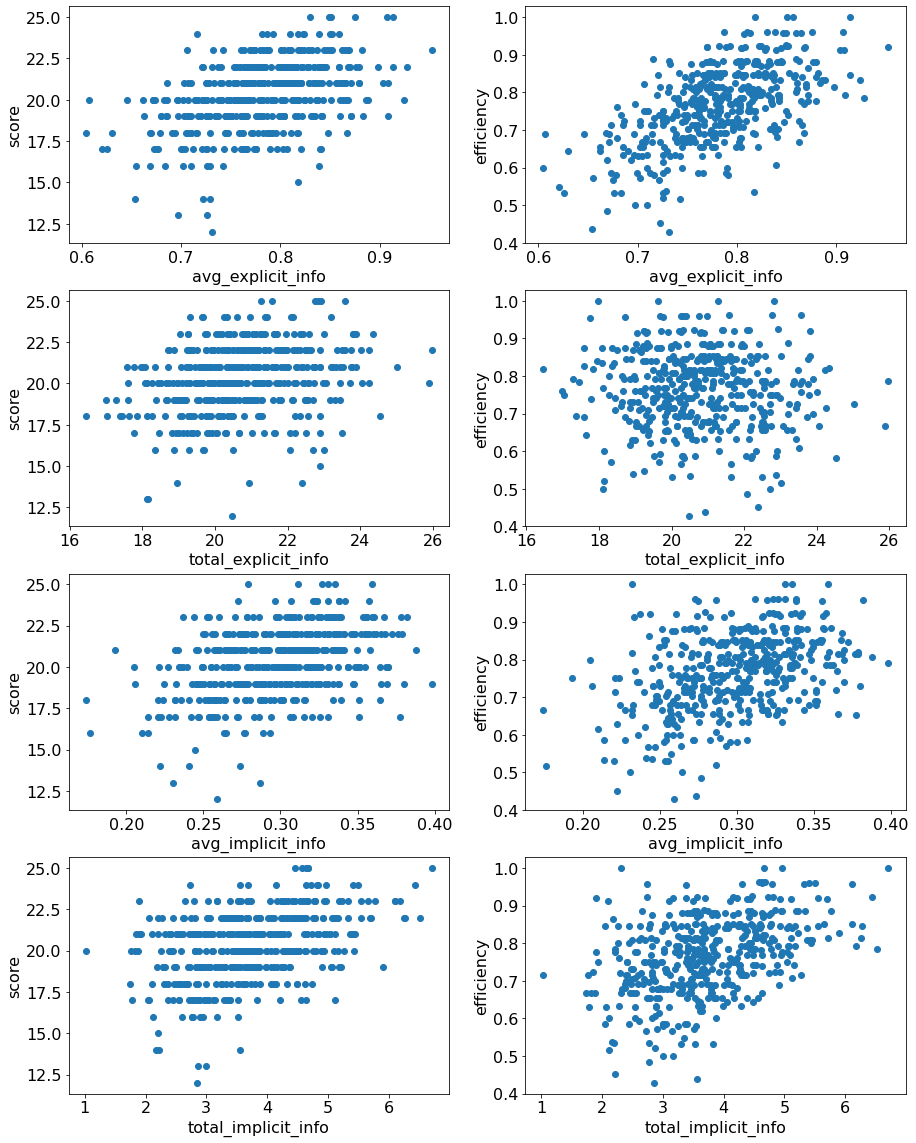

,x,y,r2
0,avg_explicit_info,score,0.188315
1,avg_explicit_info,efficiency,0.349236
2,total_explicit_info,score,0.066396
3,total_explicit_info,efficiency,0.005703
4,avg_implicit_info,score,0.157046
5,avg_implicit_info,efficiency,0.161078
6,total_implicit_info,score,0.17196
7,total_implicit_info,efficiency,0.183371


In [51]:
basic_plots(2, True)